## ABOUT TITANIC

RMS Titanic, during her maiden voyage on april 15, 1912, sank after colliding with an iceberg,killing 1502 out of 2224 passengers and crew. The tragedy is considered one of the most infamous shipwrecks in history and led to better safety guidelines for ships.

#### I have approached the project through the following process:
    
    1. Understand different features in the training dataset.
    2. Clean the features.
    3. Remove outliers.
    4. Find relation between different features and survival
    5. Find the best features using SelectKBest ( to get an optimal fit between bias and variance)
    6. Train and fit the model
    7. predict the scores using KNearestNeighbors
    8. Check accuracy 
    9. predict survival values for test csv.
    10. create final file for submission.
    

In [192]:
# importing related python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv


#importing sklearn classifiers and libraries

from sklearn.preprocessing import MinMaxScaler #normalization
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [193]:
df = pd.read_csv("train.csv")

## 1. Understand different features in dataset

the training dataset imported as pandas dataframe has 891 rows and 12 columns/features with some of the details mentioned below:

In [194]:
df.head() #port of Embarkation (C- Cherbourg,Q - Queenstown, S - Southampton)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [195]:
df.shape

(891, 12)

In [196]:
import pandas as pd 
#from pandas_profiling import ProfileReport

In [197]:
#profile = ProfileReport(df)

In [198]:
#profile.to_widgets()
#profile.to_file("titanicreport")

In [199]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [200]:
from pandas_profiling import ProfileReport

In [201]:
profile = ProfileReport(df)

In [202]:
#profile.to_widgets()
#profile.to_file("titanicreport")

## 2.CLEAN THE FEATURES

I am not interested in the following features as I believe there is no logical reason,why the passenger will survive or not

1. name
2. ticket
3. fare
4. cabin


Further,in case , i find correlation between them. I believe it will not be causation (ticket,fare,cabin can be highly correlated to passenger class).


therefore, i have dropped the above-mentioned features from the training dataset.

In [203]:
df = df.drop('Name',axis = 1,)
df = df.drop('Ticket',axis = 1,)
df = df.drop('Fare',axis = 1,)
df = df.drop('Cabin',axis = 1,)

In [204]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex             object
Age            float64
SibSp            int64
Parch            int64
Embarked        object
dtype: object

I have reated another column or feature for number of people in the family by adding SibSp,Parch and 1(for the passenger).

further i have dropped the SibSp and Parch features.

In [205]:
df['Family'] = df['SibSp'] + df['Parch'] + 1

In [206]:
df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Family
0,1,0,3,male,22.0,1,0,S,2
1,2,1,1,female,38.0,1,0,C,2
2,3,1,3,female,26.0,0,0,S,1
3,4,1,1,female,35.0,1,0,S,2
4,5,0,3,male,35.0,0,0,S,1
...,...,...,...,...,...,...,...,...,...
886,887,0,2,male,27.0,0,0,S,1
887,888,1,1,female,19.0,0,0,S,1
888,889,0,3,female,NaN,1,2,S,4
889,890,1,1,male,26.0,0,0,C,1


In [207]:
df = df.drop('SibSp',axis = 1,)
df = df.drop('Parch',axis = 1,)

I also want to check a hypothesis that while saving passengers minors were given priority over adults.

Therefore,I would be creating a new column to differentiate minors from adults. However, I will first check the age statistics of passengers.

In [208]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

since column age contains several Nan values,I will first clear those values in next section and then create the new column

## 3. Remove Outliers

Now i want to check which features have how many Nan cells.

In [209]:
feature_list = list(df.columns.values)

for feature in feature_list:
    print(feature,": ",sum(pd.isnull(df[feature])))
    
    

PassengerId :  0
Survived :  0
Pclass :  0
Sex :  0
Age :  177
Embarked :  2
Family :  0


We have 177 Nan in Age and 2 in Embarked

1. for Age, I have filled NaN with median age

2. for Embarked, I have filled NaN with port of Embarkation with Maximum Frequency

In [210]:
df['Age'] = df['Age'].fillna(df['Age'].median())

In [211]:
df['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [212]:
df['Embarked'] = df['Embarked'].fillna('S')

In [213]:
#re-checking NaNs

feature_list = list(df.columns.values)

for feature in feature_list:
    print(feature,": ",sum(pd.isnull(df[feature])))
    
    

PassengerId :  0
Survived :  0
Pclass :  0
Sex :  0
Age :  0
Embarked :  0
Family :  0


In [214]:
# checking statistics of Age column

df['Age'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

As discussed below, I have categorized the  Age featurew into following 2 categories:
    
    1. Passenger who were minors(0)
    2. Passenger who were adults(1)
    
I have created a new column named Adult and assigned value 1 to passengers who are 18 yrs old and above, 0 to passengers who were minors.

This is done to check the hypothesis that more minors survived than the adults.

In [215]:
df['Adult'] = 0

In [216]:
df['Adult'] [df['Age']>=18] = 1

C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\1944308921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Adult'] [df['Age']>=18] = 1


In [217]:
#performing a sanitory check to confirm 

## number of passengers withb age>=18 - Age column

print("Passengers more than 18 years old: ",str(len(df['Age']>=18)))

# nbumber of adult passsengers - Adult column

print("Number of Adults: ",str(len(df[df['Adult']>=1])))

Passengers more than 18 years old:  891
Number of Adults:  778


In [218]:
## dropping the age column

df = df.drop('Age',axis =1)

In [219]:
df.head()

,PassengerId,Survived,Pclass,Sex,Embarked,Family,Adult
0,1,0,3,male,S,2,1
1,2,1,1,female,C,2,1
2,3,1,3,female,S,1,1
3,4,1,1,female,S,2,1
4,5,0,3,male,S,1,1


## 4. Find relationship among different features and survival

In order to find relation between any two features. I have used pivot tables. I have used a function to save myself from code redundancy.

In [220]:
## I have created a function , which gives two parameters,

### creates a pivot table and a bar chart to show their relationship

def make_pivot (param1,param2):
    df_slice = df[[param1,param2,'PassengerId']]
    slice_pivot = df_slice.pivot_table(index = [param1],columns = [param2],aggfunc = np.size, fill_value = 0)
    
    p_chart = slice_pivot.plot.bar()
    for p in p_chart.patches:
        p_chart.annotate(str(p.get_height()),(p.get_x()*1.05,p.get_height()*1.01))
    return slice_pivot
    return p_chart
    

#### relation between survival and passenger class

PassengerId         
Pclass             1   2    3
Survived                     
0                 80  97  372
1                136  87  119

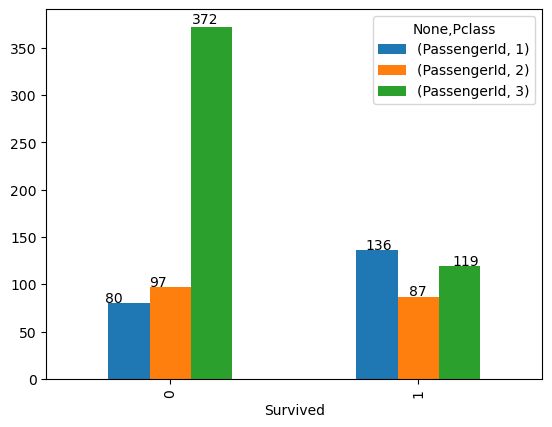

In [221]:
make_pivot("Survived","Pclass")

### Relation between Survived and Passenger Sex

PassengerId     
Sex           female male
Survived                 
0                 81  468
1                233  109

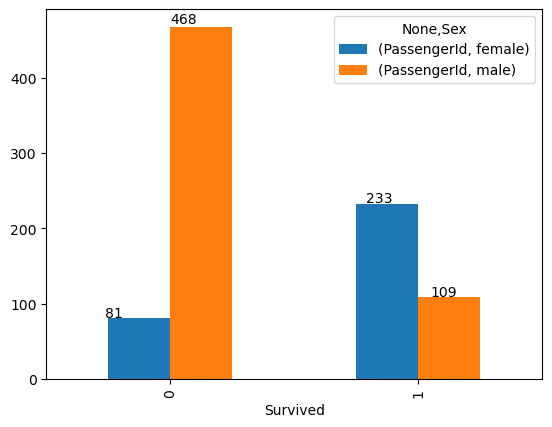

In [222]:
make_pivot("Survived","Sex")

### Relation between Survived and Port of Embarkation

PassengerId         
Embarked           C   Q    S
Survived                     
0                 75  47  427
1                 93  30  219

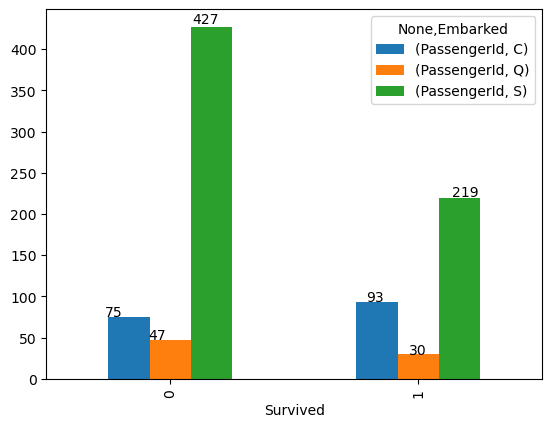

In [223]:
make_pivot("Survived","Embarked")

### Relation between Survival and Family members on-board

PassengerId                             
Family            1   2   3   4   5   6  7  8  11
Survived                                         
0                374  72  43   8  12  19  8  6  7
1                163  89  59  21   3   3  4  0  0

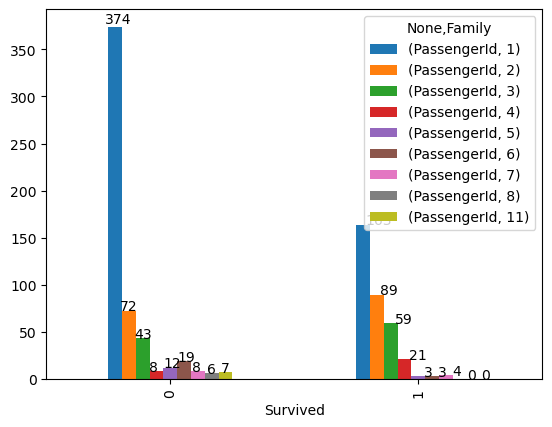

In [224]:
make_pivot("Survived","Family")

### Relation between Survival and Passenger Age

PassengerId     
Adult              0    1
Survived                 
0                 52  497
1                 61  281

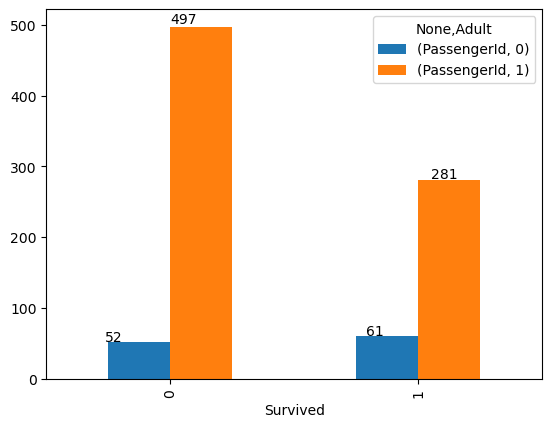

In [225]:
make_pivot("Survived","Adult")

 It does not prove my hypothesis that minors were given preference over adults while saving passengers

## 5. Find the best features using SelectKBest (to get an optimal fit between bias and variance)

from df dataframe, I have created a dataframe x, which contains all the features, and a numpy array y, which contains values of survived passengers.

In [226]:
df1 = df.filter(['Pclass','Sex','Embarked','Family','Adult'],axis = 1)

In [227]:
x = df1

In [228]:
df2 = df['Survived']

y=df2

inorder to run selectkbest, I have converted values in embarked and sex to numeric.

In [231]:

x['Embarked'].unique()


array(['S', 'C', 'Q'], dtype=object)

In [233]:
x['Embarked'][df['Embarked'] == 'S'] = 1
x['Embarked'][df['Embarked'] == 'C'] = 2
x['Embarked'][df['Embarked'] == 'Q'] = 3

C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\1638794473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Embarked'][df['Embarked'] == 'S'] = 1
C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\1638794473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Embarked'][df['Embarked'] == 'C'] = 2
C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\1638794473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Embarked'][df['

In [234]:
x['Sex'][df['Sex']=='male'] = 1
x['Sex'][df['Sex']=='female'] = 2

C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\2747583644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Sex'][df['Sex']=='male'] = 1
C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\2747583644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Sex'][df['Sex']=='female'] = 2


In [236]:
# using select kbest to get scores of all features of the dataframe

test = SelectKBest(f_classif,k='all')
test_fit = test.fit(x,y)
feat_score = test_fit.scores_.round(3)
p_values = -np.log10(test_fit.pvalues_).round(3)

In [237]:
p_values

array([24.596, 68.852,  2.851,  0.208,  3.594])

without using np log it will give very small values that are not very easy to understand anmd discrimminate rank wise 

In [238]:
feature_list = list(x.columns.values)
selected_features = test.get_support([test_fit])
selected_features

array([0, 1, 2, 3, 4], dtype=int64)

In [239]:
temp_list = []
for i in selected_features:
    temp_list.append({'Feature': feature_list[i],'P_value':p_values[i],'Score':feat_score[i]})
        
feat_select = pd.DataFrame(temp_list)

In [240]:
temp_list

[{'Feature': 'Pclass', 'P_value': 24.596, 'Score': 115.031},
 {'Feature': 'Sex', 'P_value': 68.852, 'Score': 372.406},
 {'Feature': 'Embarked', 'P_value': 2.851, 'Score': 10.259},
 {'Feature': 'Family', 'P_value': 0.208, 'Score': 0.246},
 {'Feature': 'Adult', 'P_value': 3.594, 'Score': 13.485}]

In [241]:
feat_select = feat_select.sort_values(by = 'Score',axis = 0,ascending = False,inplace = False,kind = 'quicksort',na_position = 'last')

In [242]:
feat_select = feat_select.set_index('Feature')

In [243]:
feat_select

,P_value,Score
Feature,,
Sex,68.852,372.406
Pclass,24.596,115.031
Adult,3.594,13.485
Embarked,2.851,10.259
Family,0.208,0.246


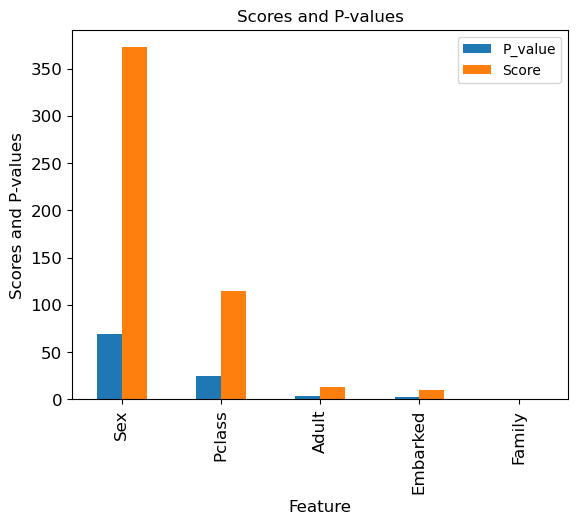

In [244]:
ax = feat_select[['P_value','Score']].plot(kind = 'bar',title = 'Scores and P-values',legend = True,fontsize = 12)
ax.set_xlabel('Feature',fontsize=12)
ax.set_ylabel('Scores and P-values', fontsize = 12)
plt.show()


Based on the score above, I have considered top 3 features - Sex,Pclass, and Adult - as my final features

In [245]:
### dropping the embarked and family column

x = x.drop('Embarked',axis = 1,)
x = x.drop('Family',axis = 1,)

In [246]:
x.head()

,Pclass,Sex,Adult
0,3,1,1
1,1,2,1
2,3,2,1
3,1,2,1
4,3,1,1


## 6. Train and Fit the Model

since test.csv do not contain survived column, I have split the training dataset to do in-house accuracy and precision testing, before submitting the entry.

In [247]:
features_train,features_test,labels_train,labels_test = train_test_split(x,y,test_size = 0.3,random_state = 42)

In [248]:
features_train.shape

(623, 3)

In [249]:
features_test.shape

(268, 3)

In [251]:
labels_train.shape

(623,)

In [252]:
labels_test.shape

(268,)

## 7. Predict the score using KNearestNeighbors

In [255]:
knn = KNeighborsClassifier()
k_range = list(range(1,10))
weights_options = ['uniform','distance']
k_grid = dict(n_neighbors = k_range,weights = weights_options)
grid = GridSearchCV(knn,k_grid,cv = 10,scoring = 'accuracy')
grid.fit(features_train,labels_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [256]:
print("best score: ",str(grid.best_score_))


best score:  0.8072452636968765


In [257]:
print("best Parameters: ",str(grid.best_params_))

best Parameters:  {'n_neighbors': 6, 'weights': 'distance'}


In [258]:
print("best Estimators: ",str(grid.best_estimator_))

best Estimators:  KNeighborsClassifier(n_neighbors=6, weights='distance')


## 8. CHeck Accuracy

In [260]:
# predicting scores

label_pred = grid.predict(features_test)

In [262]:
#calculating accuracy

acc_clf = metrics.accuracy_score(labels_test,label_pred)

print("classifier's accuracy: ",str(acc_clf))

classifier's accuracy:  0.7910447761194029


In [263]:
from sklearn.metrics import *

In [264]:
print(classification_report(labels_test,label_pred))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84       157
           1       0.88      0.58      0.70       111

    accuracy                           0.79       268
   macro avg       0.82      0.76      0.77       268
weighted avg       0.81      0.79      0.78       268



In [265]:
# calculating precision,recall, and fbeta_score

scr_clf = precision_recall_fscore_support(labels_test,label_pred,average='weighted')

print("classifier's precision: ",str(scr_clf[0]))
print("classifier's recall: ",str(scr_clf[1]))
print("classifier's fbeta_score: ",str(scr_clf[2]))

classifier's precision:  0.8077389658661381
classifier's recall:  0.7910447761194029
classifier's fbeta_score:  0.7807467111084891


## 9. Predict survival values for test.csv



Now that I have checked the accuracy, precision, and recall, I will predict the scores test.csv and export the final file for submission.

In [266]:
#importing the testing dataset

df_test = pd.read_csv(r'test.csv')

In [267]:
df_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

I need only following three features from the dataframe

1. Sex
2. Pclass
3. Adult(derived from age)

In [268]:
test_set = df_test[['Pclass','Sex','Age']].copy()


In [269]:
test_set.columns.values

array(['Pclass', 'Sex', 'Age'], dtype=object)

In [270]:
# filling NaN values in Age

test_set['Age'] = test_set['Age'].fillna(test_set['Age'].median())

In [271]:
# creating rthe adult column

test_set['Adult'] = 0
test_set['Adult'][test_set['Age']>=18] = 1

C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\3210400983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Adult'][test_set['Age']>=18] = 1


In [272]:
## dropping the age column

test_set = test_set.drop('Age',axis = 1,)

In [273]:
# converting values of column sex to numeric

test_set['Sex'][test_set['Sex']=='male'] = 1
test_set['Sex'][test_set['Sex']=='female'] = 2

C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\1745009085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Sex'][test_set['Sex']=='male'] = 1
C:\Users\gandh\AppData\Local\Temp\ipykernel_13960\1745009085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Sex'][test_set['Sex']=='female'] = 2


In [274]:
test_set.head()

,Pclass,Sex,Adult
0,3,1,1
1,3,2,1
2,2,1,1
3,3,1,1
4,3,2,1


In [275]:
#predicting survivals on test set

final_pred = grid.predict(test_set)
final_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [276]:
len(final_pred)

418

## 10. Create final file for submission

In [277]:
df_test['Survived'] = pd.Series(final_pred,index = df_test.index)


In [278]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [279]:
final_df = df_test.filter(['PassengerId','Survived'],axis = 1,)

In [280]:
final_df.shape

(418, 2)

In [281]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [282]:
final_df['Survived'].value_counts()

0    320
1     98
Name: Survived, dtype: int64

In [283]:
# exporting prediction as csv

final_df.to_csv('titanic_pred1.csv')